# Project 2 - Singapore Housing Data and Kaggle Challenge

## Part 3 - Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Importing data.
df = pd.read_csv('../data/02_feature_engineering.csv')

## 1. Pre-Modeling

We have to do a couple of things here: we need to scale the numerical columns and dummify the categorical columns.

For numerical columns, the scale of some columns are much higher than others. In order for some features not to dominate other features, we need to bring them down to a similar scale using StandardScaler.

A linear regression model will not be able to understand categorical data, so we will need to dummify them using OneHotEncoder.

I will run them both through a ColumnTransformer, which allows us to do separate transformations on different types of columns, before concatenating them back together.

### 1.1 Train Test Split

In [3]:
X = df.drop(columns= 'resale_price')
y = df['resale_price']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) 

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112329, 27)
(37443, 27)
(112329,)
(37443,)


Now, we will use OneHotEncoder on categorical data and StandardScaler on numerical data. In order to do both seamlessly, we will use a ColumnTransformer.

### 1.2 ColumnTransformer

In [5]:
# Defining numerical columns and categorical columns to be passed through SS and OHE respectively

num_columns = ['floor_area_sqm', 'mid_storey', 'max_floor_lvl', 
               'total_dwelling_units', 'mall_nearest_distance', 'hawker_nearest_distance',
               'hawker_food_stalls', 'hawker_market_stalls', 'mrt_nearest_distance',
               'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'vacancy', 
               'sec_sch_nearest_dist',
               'cutoff_point', 'age_when_sold']

cat_columns = ['full_flat_type', 'commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
               'planning_area', 'bus_interchange', 'mrt_interchange',  
                'pri_sch_affiliation', 'pri_sch_name', 'sec_sch_name', 'affiliation']

In [6]:
# Instantiating OHE, SS and CT
ohe = OneHotEncoder(min_frequency = 10)
ss = StandardScaler()
ct = make_column_transformer(
    (ohe, cat_columns),
    (ss, num_columns))

In [7]:
ct

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(min_frequency=10),
                                 ['full_flat_type', 'commercial',
                                  'market_hawker', 'multistorey_carpark',
                                  'precinct_pavilion', 'planning_area',
                                  'bus_interchange', 'mrt_interchange',
                                  'pri_sch_affiliation', 'pri_sch_name',
                                  'sec_sch_name', 'affiliation']),
                                ('standardscaler', StandardScaler(),
                                 ['floor_area_sqm', 'mid_storey',
                                  'max_floor_lvl', 'total_dwelling_units',
                                  'mall_nearest_distance',
                                  'hawker_nearest_distance',
                                  'hawker_food_stalls', 'hawker_market_stalls',
                                  'mrt_nearest_distance',
                                  'bus_stop_nearest_distance',
                                  'pri_sch_nearest_distance', 'vacancy',
                                  'sec_sch_nearest_dist', 'cutoff_point',
                                  'age_when_sold'])])

In [8]:
# Fitting and transforming using the train split, and transforming using the test split
Z_train = ct.fit_transform(X_train)
Z_test = ct.transform(X_test)

In [9]:
Z_train.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.68828799,
        -1.10725892, -0.43683001],
       [ 0.        ,  0.        ,  0.        , ...,  0.58098655,
        -1.10725892, -0.35234305],
       [ 0.        ,  0.        ,  0.        , ..., -0.06478252,
        -1.05731438,  0.57701359],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.0126372 ,
         1.93935801,  1.5908572 ],
       [ 0.        ,  0.        ,  0.        , ...,  2.37191252,
        -1.05731438,  1.5908572 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.75887798,
         1.63969077, -0.60580395]])

Now that we have done the necessary pre-modelling, we will run the model.

## 2. Modelling

We will start off by running a baseline Linear Regression. This allows us to see how well the regression runs, and identify any possible indications of underfitting (through low train and test scores), or overfitting (through high train scores, but much lower test scores).

### 2.1 Linear Regression

In [10]:
# Instantiating Linear Regression
lr = LinearRegression()
# Running a fit on train data
lr.fit(Z_train, y_train)

LinearRegression()

In [11]:
# Train score
lr_train_score = lr.score(Z_train, y_train)
print(f'The train score is {lr_train_score}.')

The train score is 0.9106674486963919.


In [12]:
# Test score
lr_test_score = lr.score(Z_test, y_test)
print(f'The test score is {lr_test_score}.')

The test score is 0.9098113900633084.


As we can see, the score is decently high at 0.91 for the train score. This means that approximately 91% of the variance of the resale price of the house can be explained by the independent variables in our model.

Also, the difference between train and test score is 0.0009. Thus, we don't see much evidence of underfitting or overfitting. Let us look at the root mean squared error.

In [13]:
# Linear Regression Root Mean Squared Error
y_test_preds_lr = lr.predict(Z_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds_lr))
print(f'The root mean squared error is {lr_rmse}.')

The root mean squared error is 43009.4607208321.


As we can see, the RMSE is 43009, which is the mean distance between the predicted values from the model and the actual values in the dataset.

Let us now see the scatterplot between the predicted and actual resale price.

r-squared = 0.9098


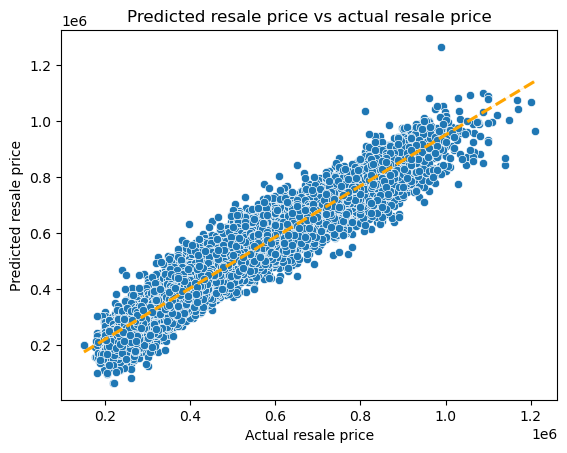

In [14]:
# Create the output DataFrame
output_df = pd.DataFrame({"Actual Price": y_test, "Predicted Price": y_test_preds_lr})

# Plot using Seaborn scatterplot
sns.scatterplot(data=output_df, x="Actual Price", y="Predicted Price")

# Plot the regression line
sns.regplot(data=output_df, x="Actual Price", y="Predicted Price", scatter=False, color="orange", line_kws={'linestyle': 'dashed'})

plt.xlabel('Actual resale price')
plt.ylabel('Predicted resale price')
plt.title('Predicted resale price vs actual resale price')

# Calculate and print the r-squared value
r_squared = r2_score(y_test, y_test_preds_lr)
plt.annotate(f"r-squared = {r_squared:.3f}", (1, 1))
print("r-squared = {:.4f}".format(r2_score(y_test, y_test_preds_lr)))#
plt.show()

We can see that the model has a strong positive trend between the predicted resale price and actual resale price.

### 2.2 Regression using `statsmodels`

We will run an Ordinary Least Square Regression using `statsmodels` as it is an easy way to view descriptive statistics. 

In this case, I'm using `statsmodels` to look at the p-value for all the numeric columns. This is to see if there are any columns that should be dropped (if their p-value is more than 0.05).

In [15]:
X = df[num_columns]

X = sm.add_constant(X)
y = df['resale_price']
ols = sm.OLS(y, X).fit()

In [16]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                 2.580e+04
Date:                Thu, 27 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:12:26   Log-Likelihood:            -1.8950e+06
No. Observations:              149772   AIC:                         3.790e+06
Df Residuals:                  149756   BIC:                         3.790e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1.358e+04   2793.306     -4.861      0.000   -1.91e+04   -8102.463
floor_area_sqm             3610.8051      9.403    383.988      0.000    3592.375    3629.236
mid_storey                 3464.8006     42.846     80.867      0.000    3380.824    3548.778
max_floor_lvl              8007.9508     48.445    165.301      0.000    7913.000    8102.902
total_dwelling_units       -239.6888      4.412    -54.325      0.000    -248.336    -231.041
mall_nearest_distance         5.5904      0.581      9.616      0.000       4.451       6.730
hawker_nearest_distance     -25.7319      0.228   -113.088      0.000     -26.178     -25.286
hawker_food_stalls         -192.7308     10.956    -17.591      0.000    -214.205    -171.257
hawker_market_stalls        170.1884      4.275     39.812      0.000     161.810     178.567
mrt_nearest_distance        -56.4387      0.472   -119.448      0.000     -57.365     -55.513
bus_stop_nearest_distance    70.4107      3.541     19.883      0.000      63.470      77.351
pri_sch_nearest_distance     12.3860      0.898     13.798      0.000      10.627      14.145
vacancy                    -139.7604     11.555    -12.095      0.000    -162.408    -117.113
sec_sch_nearest_dist         30.9039      0.656     47.089      0.000      29.618      32.190
cutoff_point                384.1282     10.124     37.942      0.000     364.285     403.971
age_when_sold             -1711.5280     24.432    -70.054      0.000   -1759.414   -1663.642
==============================================================================
Omnibus:                    19044.457   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46245.894
Skew:                           0.741   Prob(JB):                         0.00
Kurtosis:                       5.283   Cond. No.                     2.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based on the OLS regression, we do not see any columns that have a p value of more than 0.05. However, it does say that there are strong multicollinearity or other numerical problems. Let us do a multicollinearity check.

### 2.3 Multicollinearity check using VIF

I will do a multicollinearity check using Variance Inflation Factor. VIF measures the correlation among independent variables, and is easier to make decisions using VIF as opposed to a correlation matrix. This is because VIF gives one number per feature after measuring its correlation with all the other independent variables.

In [17]:
# the independent variables set
vif_columns = df.drop(columns = ['resale_price', 'full_flat_type', 'planning_area' ,
                                 'pri_sch_name', 'sec_sch_name'])
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = vif_columns.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(vif_columns.values, i)
                          for i in range(len(vif_columns.columns))]
  
print(vif_data)

                      feature        VIF
0              floor_area_sqm  19.554970
1                  mid_storey   4.723592
2               max_floor_lvl  16.590269
3                  commercial   1.326482
4               market_hawker   1.003786
5         multistorey_carpark   1.002976
6           precinct_pavilion   1.007010
7        total_dwelling_units   9.419041
8       mall_nearest_distance   5.317517
9     hawker_nearest_distance   3.755948
10         hawker_food_stalls   8.284047
11       hawker_market_stalls   3.087973
12       mrt_nearest_distance   4.624370
13            bus_interchange   3.131110
14            mrt_interchange   1.918082
15  bus_stop_nearest_distance   5.344665
16   pri_sch_nearest_distance   4.486435
17                    vacancy  11.415643
18        pri_sch_affiliation   1.206877
19       sec_sch_nearest_dist   4.044281
20               cutoff_point  61.712073
21                affiliation   1.181289
22              age_when_sold  11.132914


The following columns have a high VIF (> 5):
1. floor_area_sqm
2. max_floor_lvl
3. vacancy
4. cutoff_point
5. age_when_sold
6. total_dwelling_units
7. hawker_food_stalls
8. mall_nearest_distance
9. bus_stop_nearest_distance

Let us investigate the correlation heatmap.

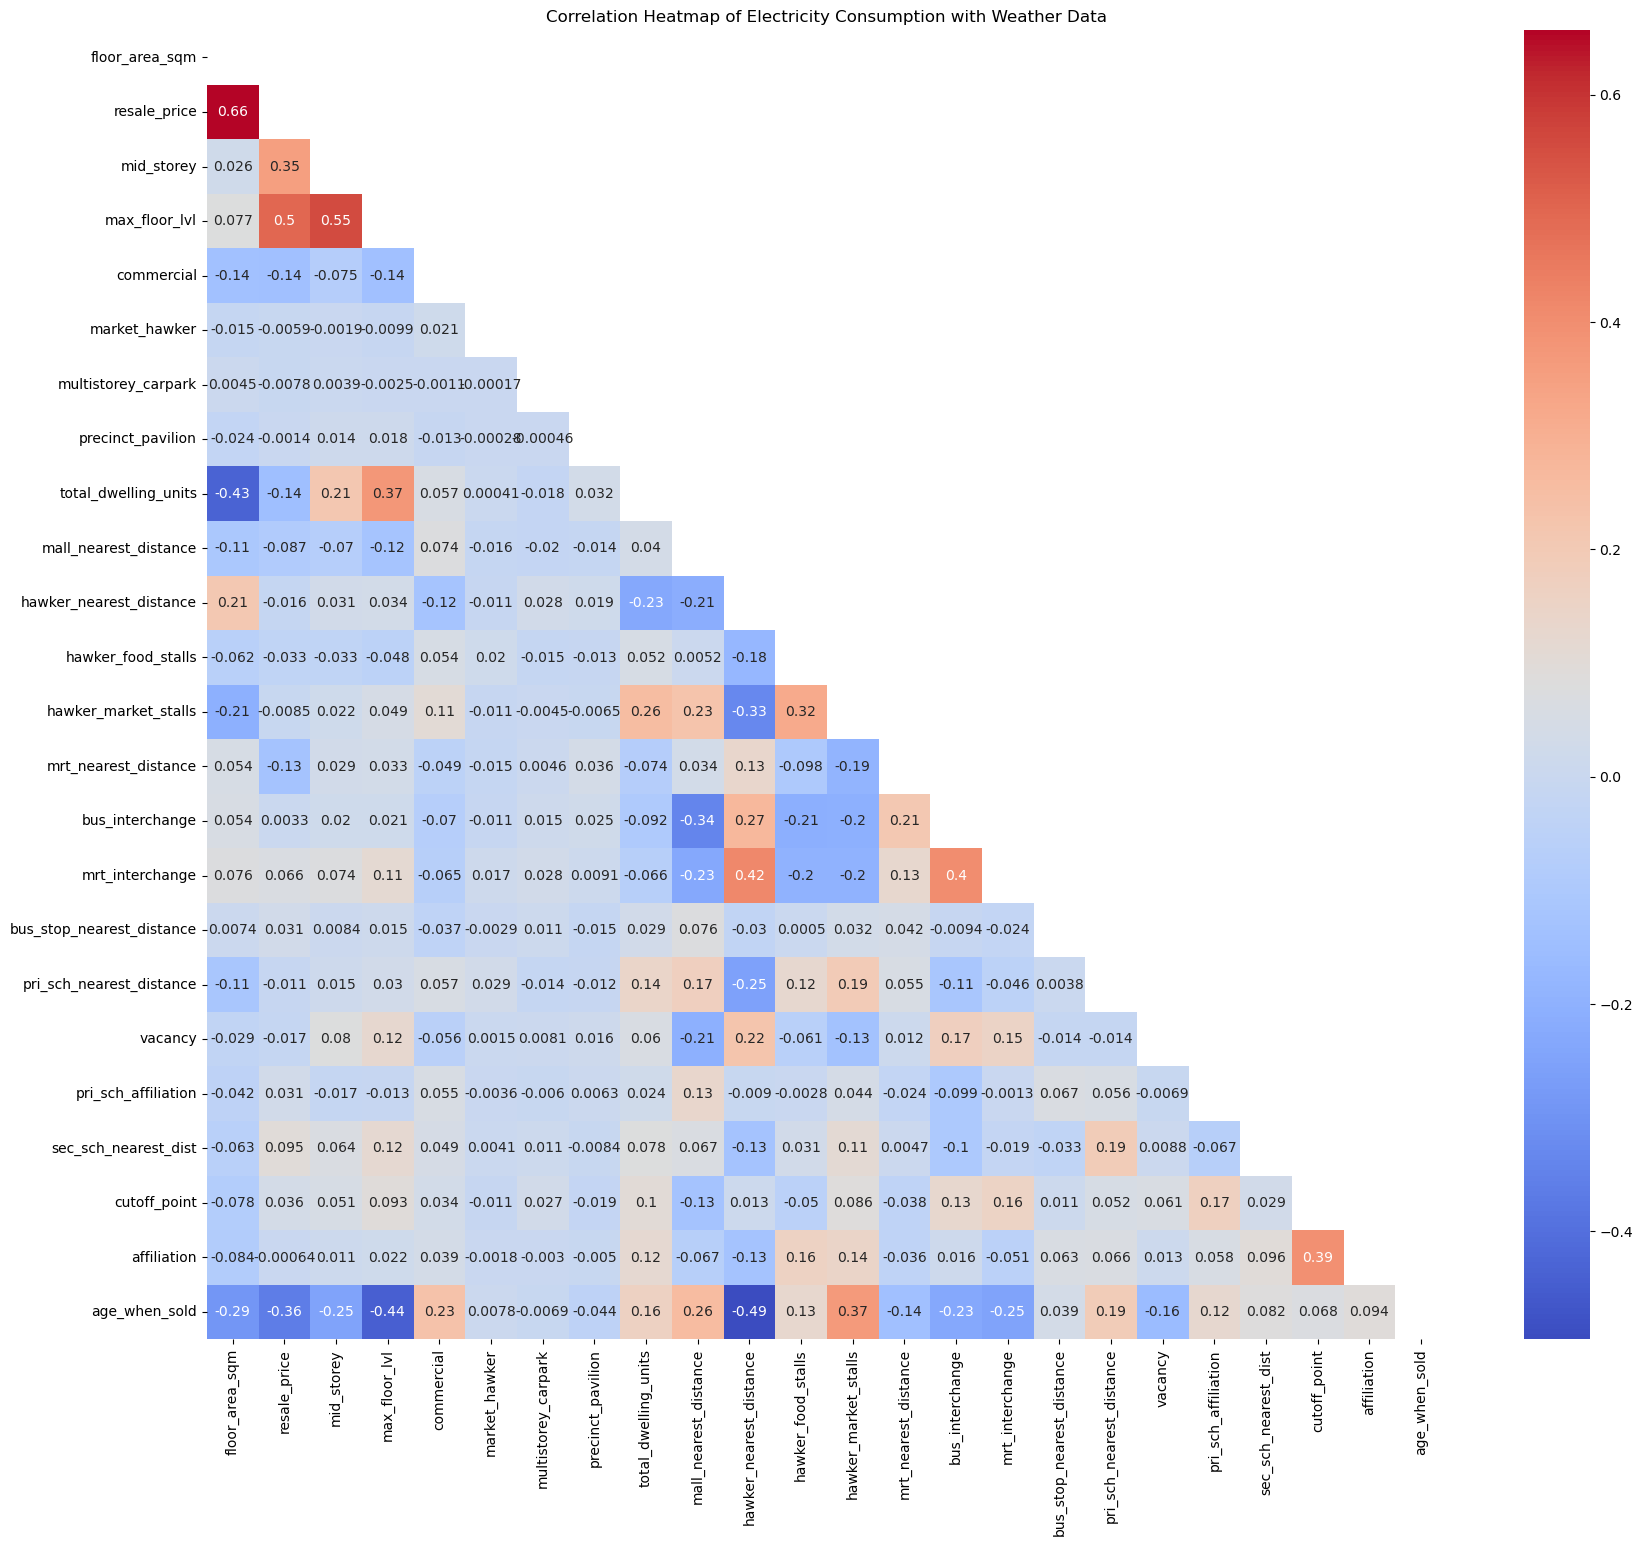

In [18]:
# plotting a heatmap with contrasting color scheme
fig, ax = plt.subplots(figsize=(20, 17))
mask = np.triu(np.ones_like(df.drop(columns = ['full_flat_type', 'planning_area' ,
                                 'pri_sch_name', 'sec_sch_name']).corr()))
sns.heatmap(df.drop(columns = ['full_flat_type', 'planning_area' ,
                                 'pri_sch_name', 'sec_sch_name']).corr(), annot=True, cmap='coolwarm', mask = mask)
plt.title('Correlation Heatmap of Electricity Consumption with Weather Data')
plt.show()

Among the columns with a high VIF, the following columns have a weak correlation with the resale price:

1. vacancy
4. cutoff_point
6. total_dwelling_units
7. hawker_food_stalls
8. bus_stop_nearest_distance

Additionally, 'max_floor_lvl' has a really strong correlation with 'mid_storey'. We will drop these in the next notebook.

Also, there are a number of columns that have very little correlation with the resale price. We will drop these in the next notebook too. These columns are:
1. market_hawker
2. multistorey_carpark
3. precinct_pavilion
4. hawker_market_stalls
5. bus_interchange
6. affiliation

## 3. Exporting File

Exporting the file to use in Notebook 04.

In [19]:
df.to_csv('../data/03_first_model.csv', index = False)